# Plot glacier terminus positions at different dates
### Jukes Liu

### Import packages and read in csv files

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import types

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [5]:
#Read in file with box coordinates
box_df = pd.read_csv(basepath+'Boxes_coords_pathrows.csv', sep=',', dtype=str)
box_df = box_df.set_index('BoxID')

#Read in file with terminus picks
termini_df = pd.read_csv(basepath+'terminuspickout_2019_07_18.csv', sep=',', dtype=str, header=1)
termini_df.replace(to_replace ="NaN", value = np.nan)

#look at the DataFrames
#termini_df.head()
#box_df

#Check column names for termini_df:
print(termini_df.columns.values)
termini_df_rownum = termini_df.shape[0]
print(termini_df_rownum)

['BoxID' 'Img_Date' 'Scale' 'Posfirst' 'Size' 'Centroid_X' 'Centroid_Y']
53


### Convert dates into DateTime objects for plotting timeseries

In [6]:
#grab dates from DataFrame:
dates = termini_df.loc[:, 'Img_Date']

#create list to hold new datetime objects
datetime_objs = []

for date in dates:
    datetime_obj = datetime.datetime.strptime(date, '%Y%m%d')
    datetime_objs.append(datetime_obj)
    
termini_df['datetimes'] = datetime_objs
termini_df.head()

,BoxID,Img_Date,Scale,Posfirst,Size,Centroid_X,Centroid_Y,datetimes
0,001,20181001,018,55686,63,127.9365234375,166.61903381347656,2018-10-01
1,001,20180825,003,55993,74,130.47291564941406,164.90545654296875,2018-08-25
2,001,20180924,007,55686,76,128.74996948242188,163.53950500488281,2018-09-24
3,001,20180830,004,55993,76,129.74998474121094,163.23684692382812,2018-08-30
4,001,20180613,004,56300,75,130.413330078125,164.7066650390625,2018-06-13


### Calculate distances from centroids to the box coordinates and the terminus change rates

In [7]:
#create a list of the subset dataframes (by BoxID) to be concatenated back together at the end
subset_dfs = []

#LOOP THROUGH AND PERFORM CALCULATIONS ON THE DATA FOR EACH BOXID
for BoxID in box_df.index:
    box_leftmost_x = np.float(box_df.loc[BoxID, 'leftmost_x'])
    box_midpoint_x = np.float(box_df.loc[BoxID, 'midpoint_x'])
#     print("Box"+BoxID, box_leftmost_x, box_midpoint_x)
    
    #subset the full DataFrame to just the Box of interest
    subset_df = termini_df[termini_df['BoxID'] == BoxID].copy()
    
    #grab the centroids as an array
    centroids_x = np.array(subset_df.loc[:, 'Centroid_X'])
    #convert to float
    centroids_x = centroids_x.astype(float)

    
    #CALCULATE THE X DISTANCE between each centroid and the leftmost point/midpoint of box
    xdist_leftmost = centroids_x - box_leftmost_x
    xdist_midpoint = centroids_x - box_midpoint_x

    #add these xdistances to the subset array
    subset_df['xdist_leftmost'] = xdist_leftmost*15
    subset_df['xdist_midpoint'] = xdist_midpoint*15
    
    
    #CALCULATE TERMINUS CHANGE RATE
    #sort the subset DataFrame by date of delineation from earliest to latest
    subset_df = subset_df.sort_values(by='datetimes', ascending=True)
#     print(subset_df)
    
    #create list to store terminus change rates
    changerates = []

    #For each entry in the subset of the overall DataFrame:
    for i in range(0, len(subset_df.index)):
        #print(i)
        #for the earliest entry, change rate is NaN
        if i == 0:
            #grab the date of the terminus position
            t_term = list(subset_df['datetimes'])[i]
            changerates.append(np.NaN)
        #for all other subsequententries
        if i > 0:
            #grab the date of the terminus position and the previous date
            t_term = list(subset_df['datetimes'])[i]
            t_term_prev = list(subset_df['datetimes'])[i-1]

            #grab the terminus position and the previous terminus position
            x_term = list(subset_df['xdist_midpoint'])[i]
            x_term_prev = list(subset_df['xdist_midpoint'])[i-1]
            
            #calculate the change in terminus position and the change in time
            deltax = x_term - x_term_prev
            deltat = t_term - t_term_prev
            #convert deltat object into raw days:
            deltat = deltat.days
#             print(BoxID, t_term, deltax, deltat)

            #calculate change rate in meters/day if deltat is not zero
            if deltat > 0:
                
                term_changerate = deltax/deltat
            else:
                #if the change in time is zero, enter 'repeat' as terminus change
                #two images from the same date were analyzed
                term_changerate = "repeat date"

            #add the change rate to the change rate list
            changerates.append(term_changerate)
    
    #print the terminus change rates (m/d)
#     for changerate in changerates:
#         print("{0:.2f}".format(changerate), "m/d")
    
    #add the terminus change rates to the subset df!
    subset_df['changerates(m/d)'] = changerates
    
    #append the subset df to the subset dfs list
    subset_dfs.append(subset_df)

#RECOMBINE THE SUBSET DFs
xdist_df = pd.concat(subset_dfs)
xdist_df.head()

,BoxID,Img_Date,Scale,Posfirst,Size,Centroid_X,Centroid_Y,datetimes,xdist_leftmost,xdist_midpoint,changerates(m/d)
4,001,20180613,004,56300,75,130.413330078125,164.7066650390625,2018-06-13,246.199951,201.199951,NaN
1,001,20180825,003,55993,74,130.47291564941406,164.90545654296875,2018-08-25,247.093735,202.093735,0.0122436
3,001,20180830,004,55993,76,129.74998474121094,163.23684692382812,2018-08-30,236.249771,191.249771,-2.16879
2,001,20180924,007,55686,76,128.74996948242188,163.53950500488281,2018-09-24,221.249542,176.249542,-0.600009
0,001,20181001,018,55686,63,127.9365234375,166.61903381347656,2018-10-01,209.047852,164.047852,-1.7431


### Plot terminus position and terminus change vs. datetime for each BoxID

In [8]:
#set dictionary to call info in DataFrame for each individual BoxID
termini_bybox = {}

#grab dataframe for each individual BoxID
for BoxID in box_df.index:
    #grab termini pick info for that BoxID
    termini_bybox_df = xdist_df[xdist_df['BoxID'] == BoxID].copy()
    #update to dictionary
    termini_bybox.update( {BoxID: termini_bybox_df} )

Plot for each BoxID

14 2785.67138671875 nan
12 1480.330810546875 -17.88137775577911
13 1409.30419921875 -14.205322265625
11 1389.3099975585938 -0.79976806640625
10 1906.131591796875 73.83165631975446


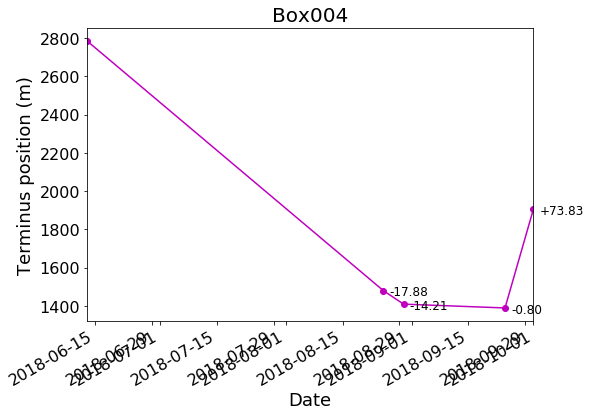

In [9]:
#SET BOX OF INTEREST (BOI) to plot
BOI = '004'
df_BOI = termini_bybox[BOI]

#drop any values that are NaNs since they plot improperly
for index, row in df_BOI.iterrows():
    print(index, row['xdist_midpoint'], row['changerates(m/d)'])
    if np.isnan(row['xdist_midpoint']):
        df_BOI = df_BOI.drop(index, axis=0)
        print("^ Row dropped")

#set index to changerate for ease of plotting
df_BOI = df_BOI.set_index('changerates(m/d)')


#PLOT TERMINUS POSITION 
df_BOI.plot(x='datetimes', y='xdist_midpoint', legend=False, style='mo-', figsize=(8,6))
plt.title("Box"+BOI, fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Terminus position (m)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#LABEL EACH POINT BY TERMINUS CHANGE RATE
for i, changerate in enumerate(df_BOI.index):
#     print(type(changerate), changerate)
    #If the rate is a float (number or Nan), format it
    if isinstance(changerate, float):
        txt = str("{0:.2f}".format(changerate))
        #If it's positive, add a + for clarity:
        if changerate > 0:
            txt = "+"+txt
        #don't plot the nans
        if np.isnan(changerate):
            txt = " "
    #for others, plot the string
    else:
        txt = str(changerate)
    plt.annotate(txt, 
                 xy=(list(df_BOI['datetimes'])[i] ,list(df_BOI['xdist_midpoint'])[i]), 
                 fontsize=12,
                 xytext=(6 ,-5), 
                 textcoords='offset points')

#SAVE FIGURE
plt.savefig(basepath+"Terminusposition_Box"+BOI+".png", dpi=200)

###  Remnant code on plotting teminus changes:

In [435]:
# #PLOT:
# plt.figure(figsize=(12, 8))
# plt.plot(changerates.keys(), changerates.values(),'rx', markersize=15)

# #Label the points by the change rate (m/d)
# for i, changerate in enumerate(changerates.values()):
#     txt = "{0:.2f}".format(changerate)
#     plt.annotate(txt, xy=(list(changerates.keys())[i], list(changerates.values())[i]), fontsize=16)

# plt.title("Box"+BOI, fontsize=20)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Terminus change (m/d)', fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=16)
# plt.gca().invert_yaxis()

# plt.show()